# Tagup data science challenge

ExampleCo, Inc has a problem: maintenance on their widgets is expensive. They have contracted with Tagup to help them implement predictive maintenance. They want us to provide a model that will allow them to prioritize maintenance for those units most likely to fail, and in particular to gain some warning---even just a few hours!---before a unit does fail.

They collect two kinds of data for each unit. First, they have a remote monitoring system for the motors in each unit, which collects information about the motor (rotation speed, voltage, current) as well as two temperature probes (one on the motor and one at the inlet). Unfortunately, this system is antiquated and prone to communication errors, which manifest as nonsense measurements. Second, they have a rule-based alarming system, which can emit either warnings or errors; the system is known to be noisy, but it's the best they've got. 

They have given us just over 100MB of historical remote monitoring data from twenty of their units that failed in the field. The shortest-lived units failed after a few days; the longest-lived units failed after several years. Typical lifetimes are on the order of a year. This data is available in .csv files under `data/train` in this repository. In addition, they have provided us with operating data from their thirty active units for the past month; this data is available under `data/test` in this repository.

You have two main objectives. First, **tell us as much as you can about the process that generated the data**. Does it show meaningful clustering? Do the observations appear independent? How accurately can we forecast future observations, and how long a window do we need to make an accurate forecast? Feel free to propose multiple models, but be sure to discuss the ways each is useful and the ways each is not useful. Second, **predict which of the thirty active units are most likely to fail**. The data from these units are in `data/test`. Be sure to quantify these predictions, and especially your certainty.

A few notes to help:
1. A good place to start is by addressing the noise due to comm errors. 
2. There is a signal in the data that you can identify and exploit to predict failure.
3. If you can't find the signal in the noise, don't despair! We're much more interested in what you try and how you try it than in how successful you are at helping a fictional company with their fictional problems.
4. Feel free to use any libraries you like, or even other programming languages. Your final results should be presented in this notebook, however.
5. There are no constraints on the models or algorithms you can bring to bear. Some ideas include: unsupervised clustering algorithms such as k-means; hidden Markov models; forecasting models like ARMA; neural networks; survival models built using features extracted from the data; etc.
6. Don't feel compelled to use all the data if you're not sure how. Feel free to focus on data from a single unit if that makes it easier to get started.
7. Be sure to clearly articulate what you did, why you did it, and how the results should be interpreted. In particular you should be aware of the limitations of whatever approach or approaches you take.
8. Don't hesitate to reach out with any questions.

,rpm,motor_voltage,motor_current,motor_temp,inlet_temp
count,9.171500e+04,9.171500e+04,9.171500e+04,9.171500e+04,9.171500e+04
mean,-8.111152e+46,-4.431337e+60,-1.387827e+56,-6.640742e+69,-1.937422e+48
std,2.456380e+49,1.903274e+63,4.202968e+58,2.011115e+72,5.867349e+50
min,-7.439020e+51,-5.565298e+65,-1.272847e+61,-6.090557e+74,-1.776896e+53
25%,1.017725e+03,2.311319e+02,3.239347e+01,1.179731e+02,6.489677e+01
50%,1.066347e+03,2.667104e+02,3.944687e+01,1.564521e+02,7.799157e+01
75%,1.106721e+03,2.993994e+02,4.607173e+01,1.978223e+02,9.086132e+01
max,7.978110e+44,1.500194e+65,1.555360e+55,3.117856e+55,1.710299e+40


,message
count,4
unique,4
top,warning
freq,1


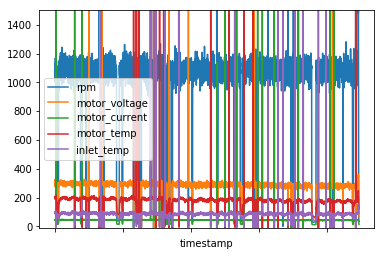

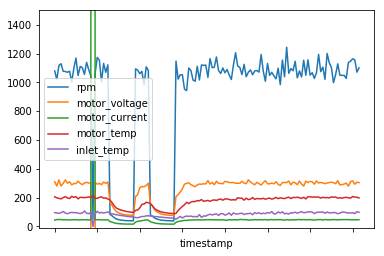

In [1]:
# To help you get started...
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

def load_rms(filename):
    return pd.read_csv(filename, index_col="timestamp")
def load_alarms(filename):
    return pd.read_csv(filename, header=None, names=["timestamp", "message"], index_col="timestamp").describe()

rms = load_rms('data/train/unit0000_rms.csv')
alarms = load_alarms('data/train/unit0000_alarms.csv')
rms.loc["2005-08-01":"2005-09-01"].plot(ylim=(-10, 1500))
rms.loc["2005-08-01":"2005-08-02"].plot(ylim=(-10, 1500))

display(rms.describe())
display(alarms.describe())

#### Importing the required pakages ####

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from pandas.api.types import is_numeric_dtype
sns.set(color_codes=True)
from sklearn import preprocessing
from scipy import stats
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import xgboost as xgb
import decimal

#### This is a helper function taken from the following source ####
https://github.com/mrahtz/sanger-machine-learning-workshop/blob/master/learn_utils.py

In [3]:

def sliding_chunker(data, window_len, slide_len):
    """
    Split a list into a series of sub-lists, each sub-list window_len long,
    sliding along by slide_len each time. If the list doesn't have enough
    elements for the final sub-list to be window_len long, the remaining data
    will be dropped.
    e.g. sliding_chunker(range(6), window_len=3, slide_len=2)
    gives [ [0, 1, 2], [2, 3, 4] ]
    """
    chunks = []
    for pos in range(0, int(len(data)), int(slide_len)):
        chunk = np.copy(data[pos:pos+window_len])
        if len(chunk) != window_len:
            continue
        chunks.append(chunk)

    return chunks

def plot_waves(waves, step):
    """
    Plot a set of 9 waves from the given set, starting from the first one
    and increasing in index by 'step' for each subsequent graph
    """
    plt.figure()
    n_graph_rows = 3
    n_graph_cols = 3
    graph_n = 1
    wave_n = 0
    for _ in range(n_graph_rows):
        for _ in range(n_graph_cols):
            axes = plt.subplot(n_graph_rows, n_graph_cols, graph_n)
            axes.set_ylim([-100, 150])
            plt.plot(waves[wave_n])
            graph_n += 1
            wave_n += step
    # fix subplot sizes so that everything fits
    plt.tight_layout()
    plt.show()

def reconstruct(data, window, clusterer):
    """
    Reconstruct the given data using the cluster centers from the given
    clusterer.
    """
    window_len = int(len(window))
    slide_len = window_len/2
    segments = sliding_chunker(data, window_len, slide_len)
    reconstructed_data = np.zeros(len(data))
    for segment_n, segment in enumerate(segments):
        # window the segment so that we can find it in our clusters which were
        # formed from windowed data
        segment *= window
        nearest_match_idx = clusterer.predict(segment)[0]
        nearest_match = np.copy(clusterer.cluster_centers_[nearest_match_idx])

        pos = segment_n * slide_len
        reconstructed_data[pos:pos+window_len] += nearest_match

    return reconstructed_data

#### Importing unit0 data from files stored on my local drive ####
If the noteboook is being run on another machine, might need to change these file paths depending on where the data is pulled from  

In [4]:
#unit0   = pd.read_csv("/Users/suhriddeshmukh/Documents/MIT_Files/PracticeCodes/Tagup/data-science-challenge-master/data/train/unit0000_rms.csv") 
#alarms0= pd.read_csv("/Users/suhriddeshmukh/Documents/MIT_Files/PracticeCodes/Tagup/data-science-challenge-master/data/train/unit0000_alarms.csv")  
#unit0.head(5)
unit0   = pd.read_csv("data/train/unit0000_rms.csv") 
alarms0= pd.read_csv("data/train/unit0000_alarms.csv")  
unit0.head(5)

,timestamp,rpm,motor_voltage,motor_current,motor_temp,inlet_temp
0,2003-12-13 19:56:43.777979848,0.150438,-0.059544,0.045503,5.084823,0.019528
1,2003-12-13 20:07:32.457298714,0.511660,0.627101,0.208669,7.334172,2.081454
2,2003-12-13 20:13:43.182783330,0.824233,1.732618,0.286401,8.843053,3.485346
3,2003-12-13 20:27:19.295198297,1.506626,3.115258,0.483992,11.749493,6.041188
4,2003-12-13 20:35:08.719032171,2.034869,3.923323,0.851620,12.947061,7.309662


In [5]:
# Getting information about the data types
unit0.timestamp = pd.to_datetime(unit0.timestamp)
unit0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91715 entries, 0 to 91714
Data columns (total 6 columns):
timestamp        91715 non-null datetime64[ns]
rpm              91715 non-null float64
motor_voltage    91715 non-null float64
motor_current    91715 non-null float64
motor_temp       91715 non-null float64
inlet_temp       91715 non-null float64
dtypes: datetime64[ns](1), float64(5)
memory usage: 4.2 MB


### Is the data noisy? ###
As can be seen from the summary statistics, there is so much noise in the data that the means and the standard deviation get skewed to one side.

In [6]:
unit0.head()
unit0.describe()

,rpm,motor_voltage,motor_current,motor_temp,inlet_temp
count,9.171500e+04,9.171500e+04,9.171500e+04,9.171500e+04,9.171500e+04
mean,-8.111152e+46,-4.431337e+60,-1.387827e+56,-6.640742e+69,-1.937422e+48
std,2.456380e+49,1.903274e+63,4.202968e+58,2.011115e+72,5.867349e+50
min,-7.439020e+51,-5.565298e+65,-1.272847e+61,-6.090557e+74,-1.776896e+53
25%,1.017725e+03,2.311319e+02,3.239347e+01,1.179731e+02,6.489677e+01
50%,1.066347e+03,2.667104e+02,3.944687e+01,1.564521e+02,7.799157e+01
75%,1.106721e+03,2.993994e+02,4.607173e+01,1.978223e+02,9.086132e+01
max,7.978110e+44,1.500194e+65,1.555360e+55,3.117856e+55,1.710299e+40


There is clearly a lot of noise in the data. The noisy points are so large in magnitude that they are skewing the means and other summary statistics. Lets explore this thought further by creating a few histograms for unit 0.

In [7]:
unit0.dtypes

timestamp        datetime64[ns]
rpm                     float64
motor_voltage           float64
motor_current           float64
motor_temp              float64
inlet_temp              float64
dtype: object

In [8]:
unit0.shape

(91715, 6)

#### Histogtams on unit0 parameters to detect noise in the data ####

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1a47fa90>,
      dtype=object)

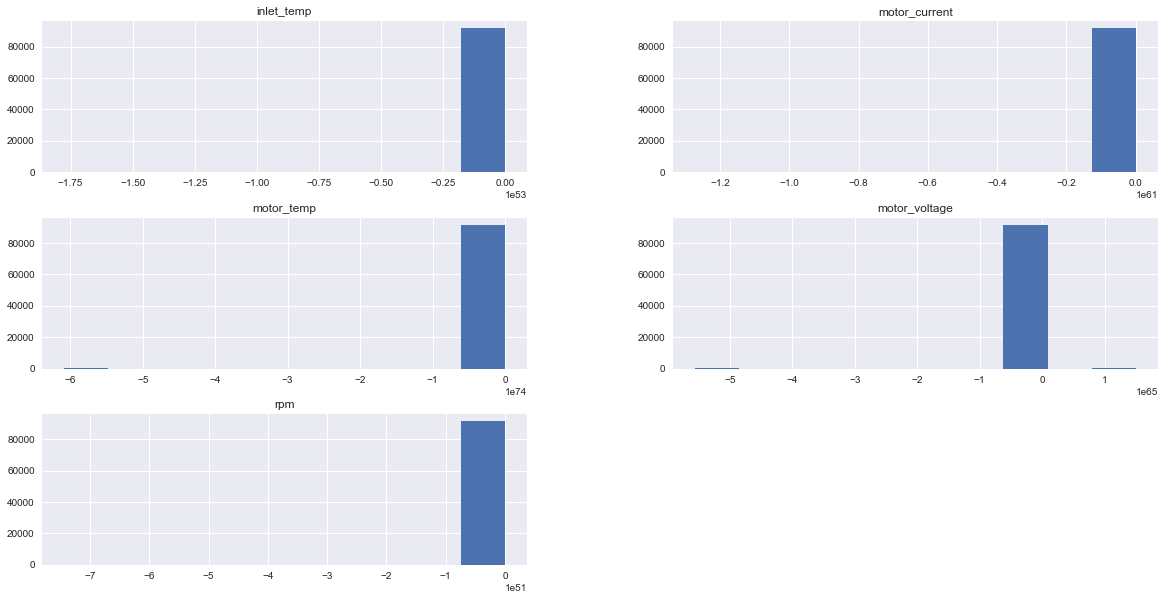

In [9]:
unit0.hist(figsize=(20,10))

As can be seen from the above histograms, the data is extremely noisy and the magnitude of the outliers is also very large. The order of magnitude is so nonsensical that a good stistical outlier detection method based on Z-score cannot be performed as the Z-score uses standard deviation and those values are also not the right order of magnitude. In situations like these, heuristic methods for outlier detection and data cleaning need to be applied. Since the data collected on unit0 (and other units) is at such a granular level (every 10 minutes or so), we can expect the data to be relatively smooth on a minute to minute basis if the unit is supposed to be working. Therefore to detect the outliers in this case, the data between thr 5 percentile and 95 percentile range was considered. This quantil range is shown in the table below.

In [10]:
# Test the 5%-95% range for all the values
unit0.quantile([0.05,0.95])

,rpm,motor_voltage,motor_current,motor_temp,inlet_temp
0.05,23.291871,46.309046,9.389603,67.767163,46.768874
0.95,1163.199004,320.489176,49.248759,220.712401,103.047319


In [11]:
def clean_data(data):
    low = 0.05
    high = 0.95
    quantiles = data.quantile([low,high])
    for col_name in list(data.columns):
        if is_numeric_dtype(data[col_name]):
            data = data[(data[col_name] > quantiles.loc[low,col_name]) & (data[col_name] < quantiles.loc[high,col_name])]
    
    return data

unit0_clean = clean_data(unit0)

In [12]:
unit0_clean.head()

,timestamp,rpm,motor_voltage,motor_current,motor_temp,inlet_temp
59,2003-12-14 05:45:57.604204392,1071.265218,220.091101,29.917097,89.069642,53.178325
60,2003-12-14 05:57:27.841865348,1121.121953,220.294005,30.317449,91.668490,50.227658
63,2003-12-14 06:25:18.555832033,1134.563007,216.858225,28.690638,93.489985,47.439531
64,2003-12-14 06:35:38.064804012,1127.632611,215.315746,29.825574,87.256581,49.198645
66,2003-12-14 06:55:18.781165507,1059.858213,233.556643,29.929805,95.151337,49.309509


In [13]:
unit0_clean.info() # Around 20308 data points were "cleaned"

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71407 entries, 59 to 91714
Data columns (total 6 columns):
timestamp        71407 non-null datetime64[ns]
rpm              71407 non-null float64
motor_voltage    71407 non-null float64
motor_current    71407 non-null float64
motor_temp       71407 non-null float64
inlet_temp       71407 non-null float64
dtypes: datetime64[ns](1), float64(5)
memory usage: 3.8 MB


Once the data was cleaned using the 5%-95% rule, the distrubution of different paramters was again evaluated to see if they show some meaningful ranges in their values. Lets plot the histograms again with the cleaned data to get a better sense of how the data looks without the noise. As can be seen from the histograms below, we get much more resonable ranges for the values corressponding to different parameters.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a19353438>,
      dtype=object)

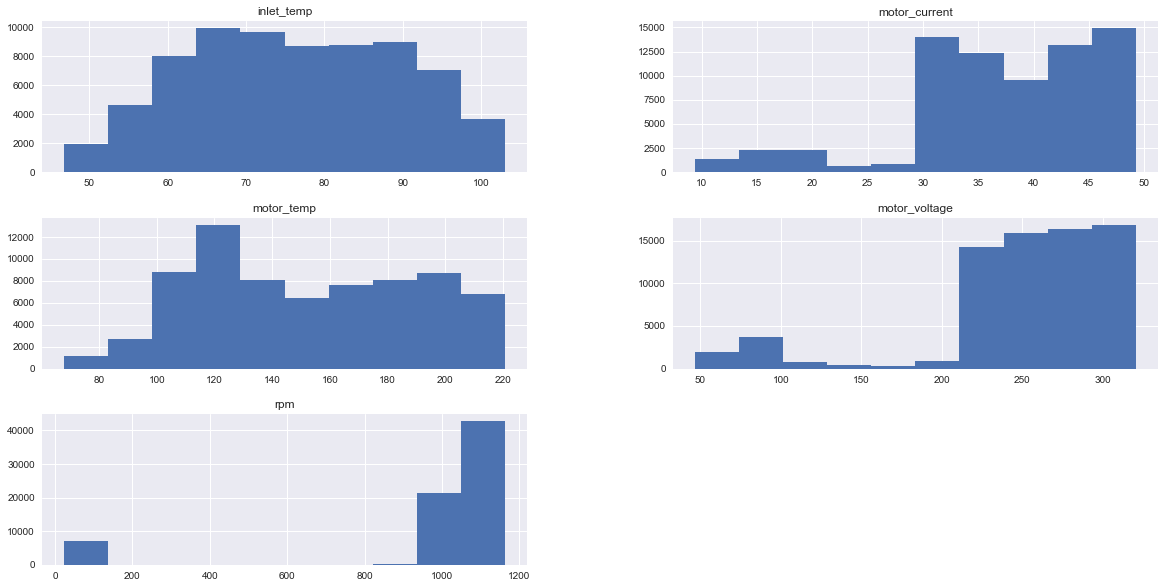

In [14]:
unit0_clean.hist(figsize=(20,10))

#### Is the data correlated or does it come from an independent process ?####
We can expect certain correlations in the data due to the physics of the process. For example, higher RPM will lead to higher frictional loss and therefore higher heat generation leading to an increase in the temperature. Also, higher power relates to higher voltage and higher RPM. Therefore we expect to see voltage and RPM to be positively correlated also. As can be seen from the correlation matrix further down in the notebook, these results validate our intuition. Therefore it can be concluded that the data is not generated from a completely independent process. There are a few correlations, like the one between RPM and motor_temp that I would have expected to be higher than what it is, and that is something that could be explored further.

The plots below show the RPM vs. Time, Current vs. Time and Voltage vs. Time for unit 0. These plots help us visualize the Ohms law dependency of V = IR. We can see that the patterns in the voltage and current relationships are very similar. 



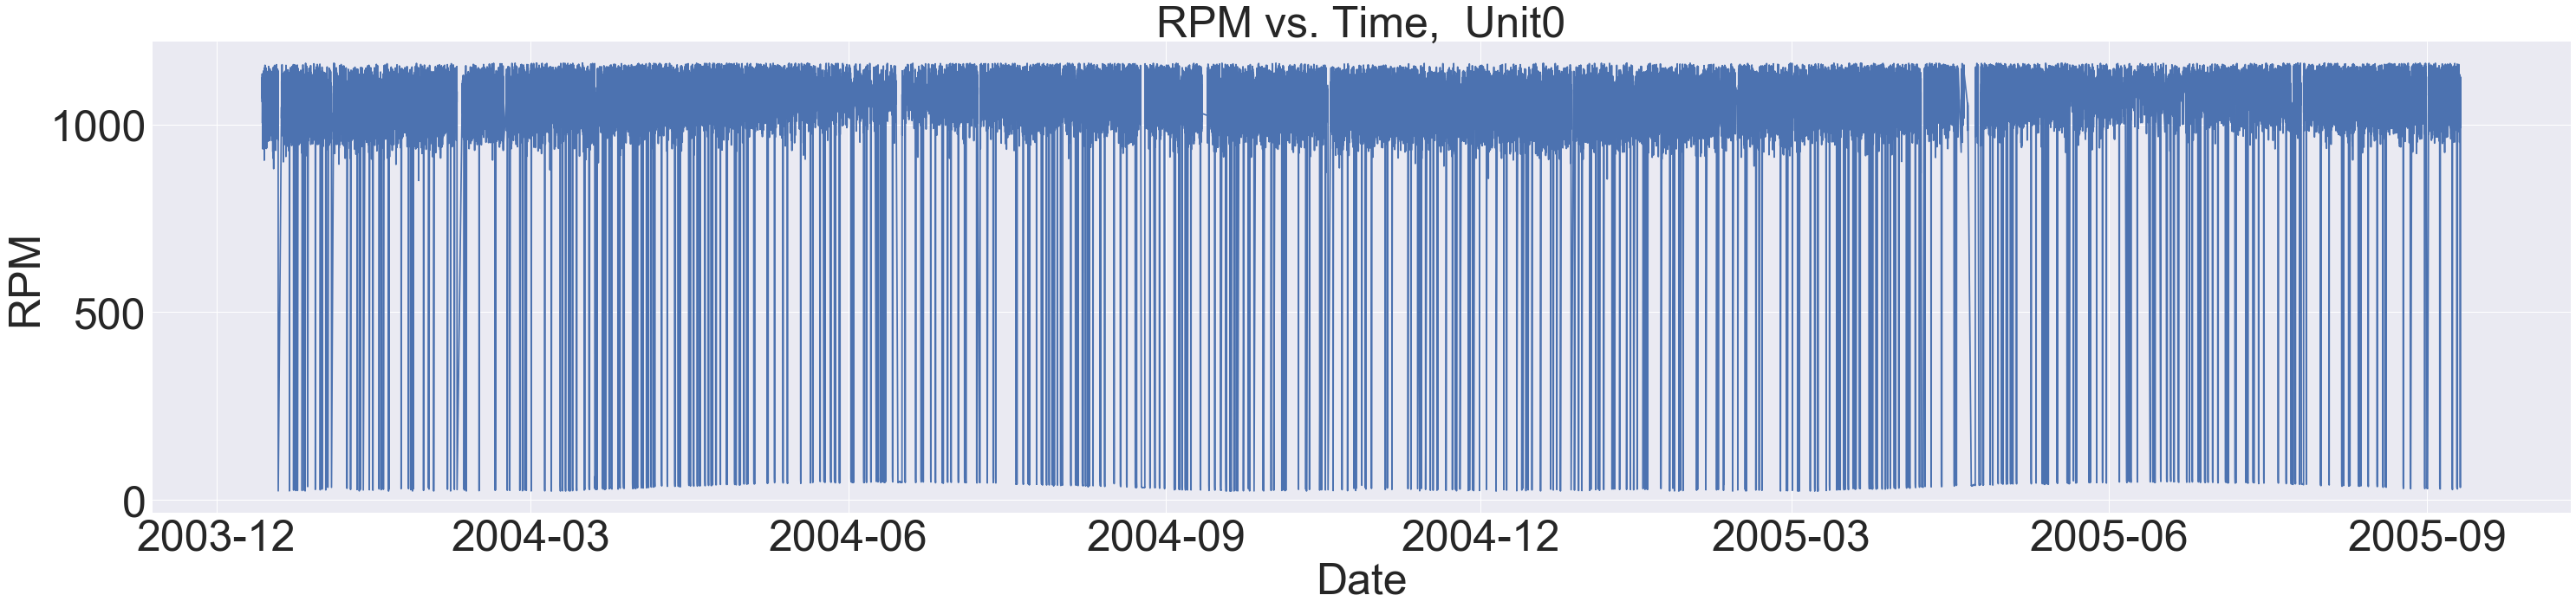

In [15]:
# RPM plot of cleaned data for unit 0
plt.figure(figsize=(50,10))
plt.xlabel('Date',fontsize = 50)
plt.ylabel('RPM',fontsize = 50)
plt.title('RPM vs. Time,  Unit0',fontsize = 50)
plt.plot(unit0_clean.timestamp,unit0_clean.rpm)
plt.tick_params(axis = 'both', which = 'major', labelsize = 50)


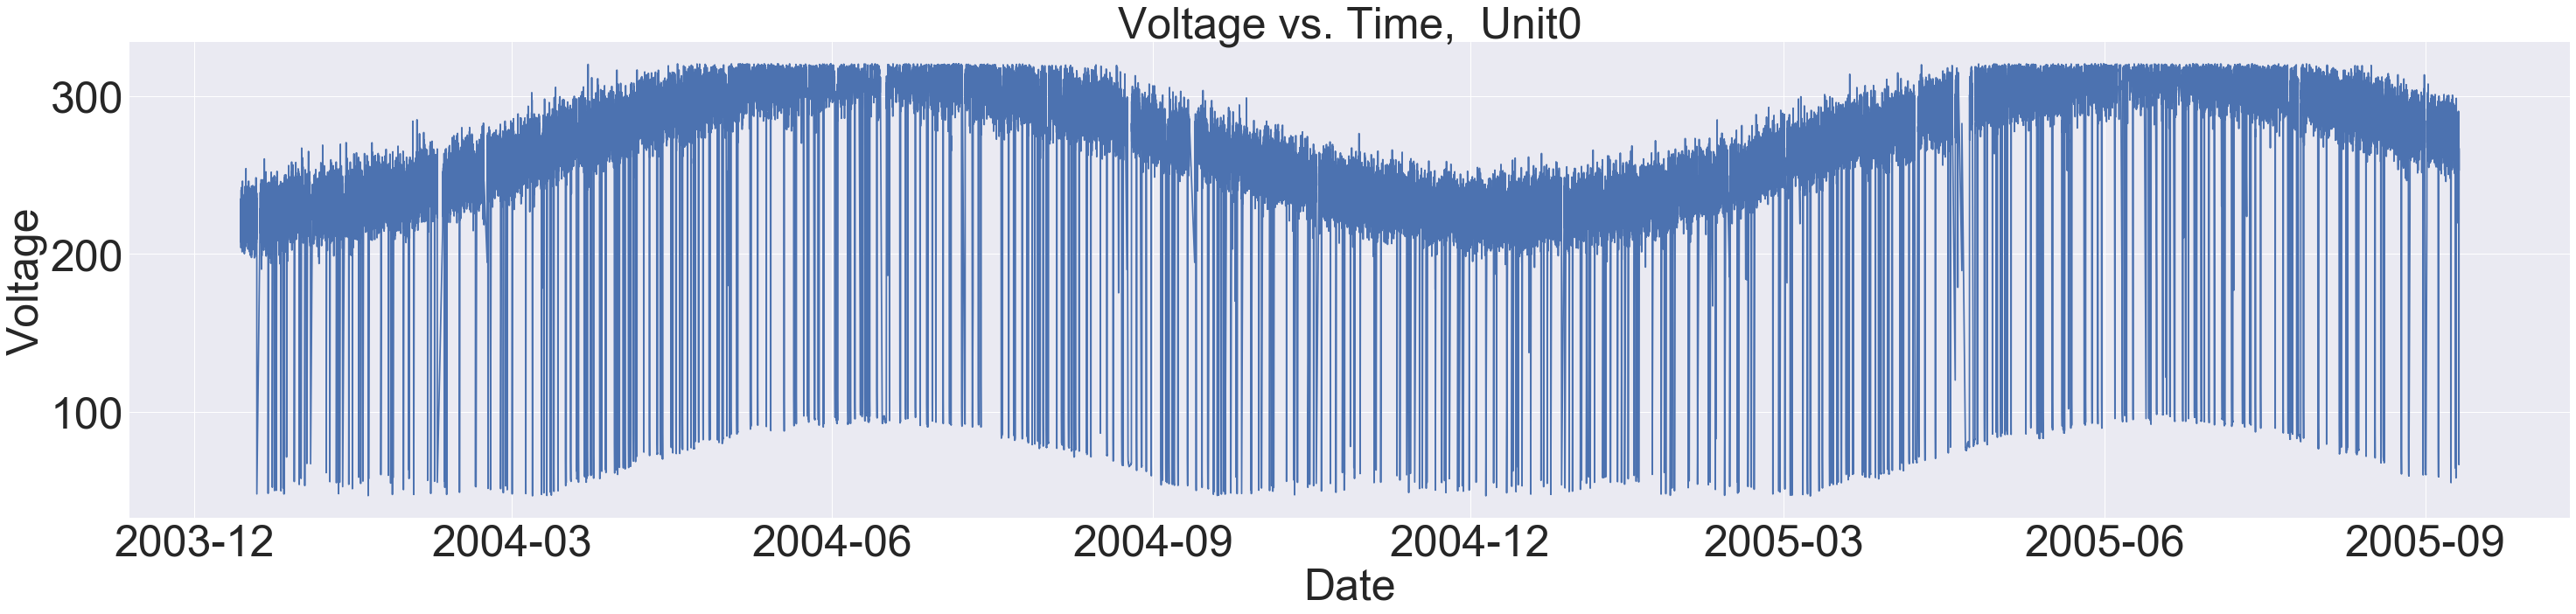

In [16]:
# Voltage plot of cleaned data for unit 0
plt.figure(figsize=(50,10))
plt.xlabel('Date',fontsize = 50)
plt.ylabel('Voltage',fontsize = 50)
plt.title('Voltage vs. Time,  Unit0',fontsize = 50)
plt.plot(unit0_clean.timestamp,unit0_clean.motor_voltage)
plt.tick_params(axis = 'both', which = 'major', labelsize = 50)

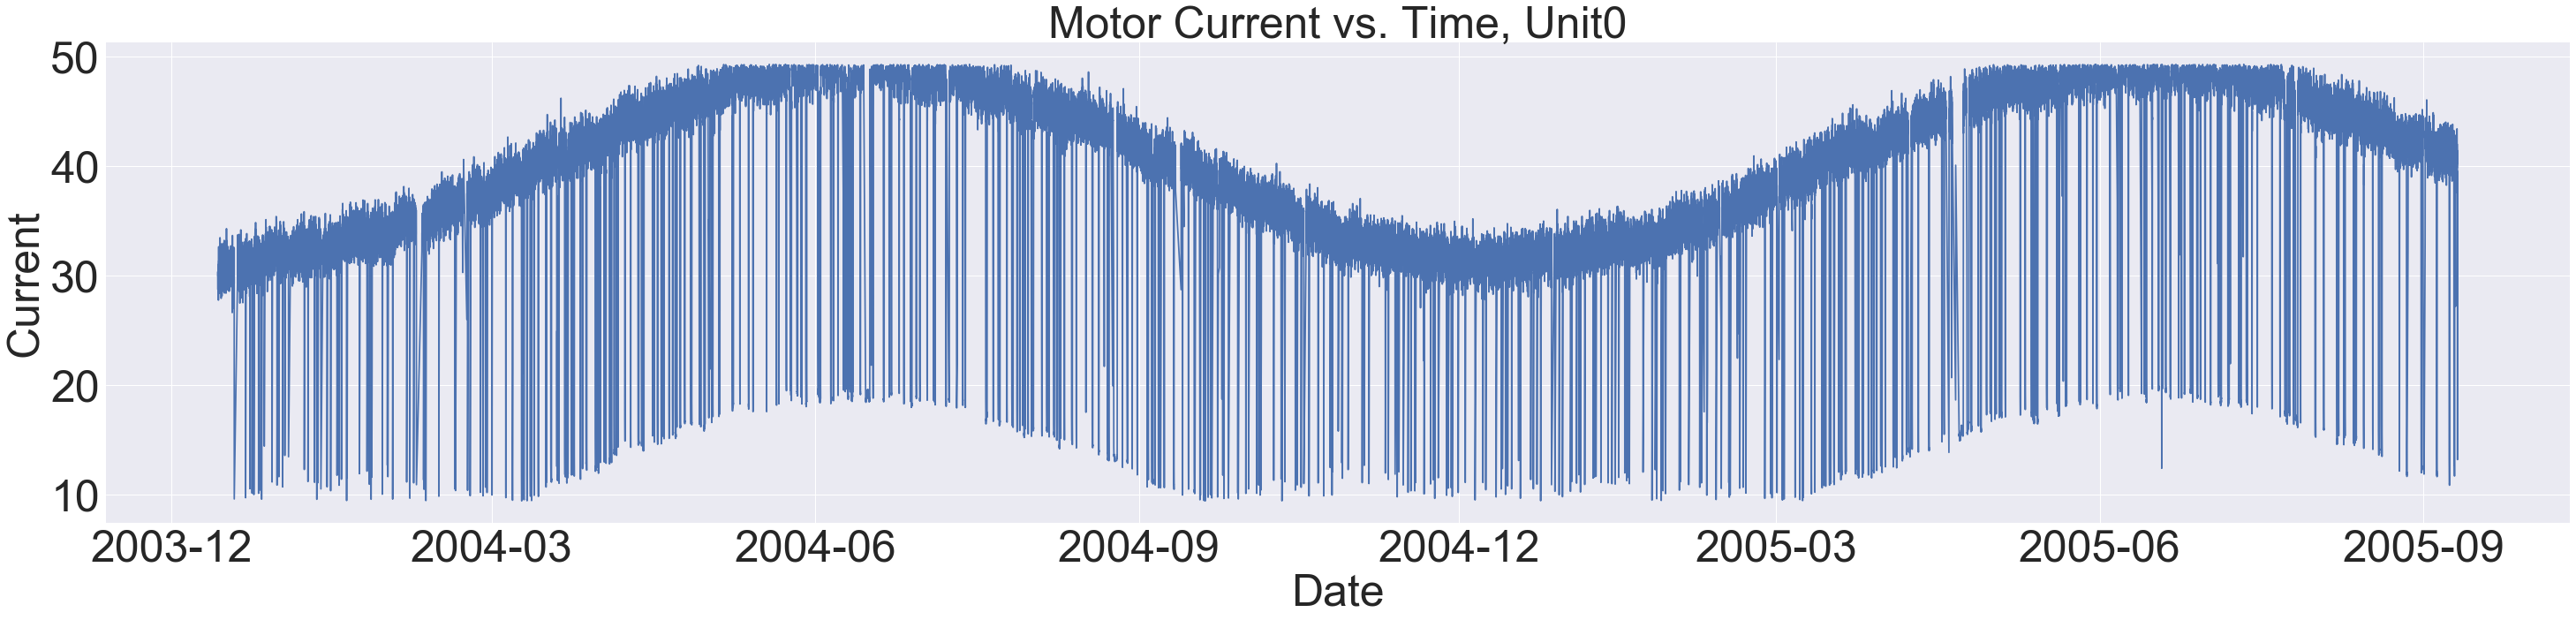

In [17]:
# Motor Current plot of cleaned data for unit 0
plt.figure(figsize=(50,10))
plt.xlabel('Date',fontsize = 50)
plt.ylabel('Current',fontsize = 50)
plt.title('Motor Current vs. Time, Unit0',fontsize = 50)
plt.plot(unit0_clean.timestamp,unit0_clean.motor_current)
plt.tick_params(axis = 'both', which = 'major', labelsize = 50)

As can be seen from the plots above, the cleaned data for unit 0 seems to be much clearer in terms of showing interesting trends. For example, we see the Ohms law relationship, V = IR, in the plots of the current and the voltage above. The two plots show similar trends over time which is expected. 

In [18]:
unit0_clean.set_index('timestamp',drop=True,inplace=True)

### Analyzing data at a more granular level to better understand trends ###

In order to study the data carefully it is better to plot the data for a shorter period of time and see if we detect any periodicity. Since these motors seem to be functioning round the clock, visualizing the data for a day or two might provide some insight. The following plot shows the parameters of unit0 plotted on August 1st-2nd, 2005. As can be seen from the plot, the unit appears to be running fine most of the time with the RPM hovering around 1100, but there is a sudden drop twice between 4am-11am. This drop in the RPM suggests an abnormal behavior and might be a good indicator for predicting failure. 

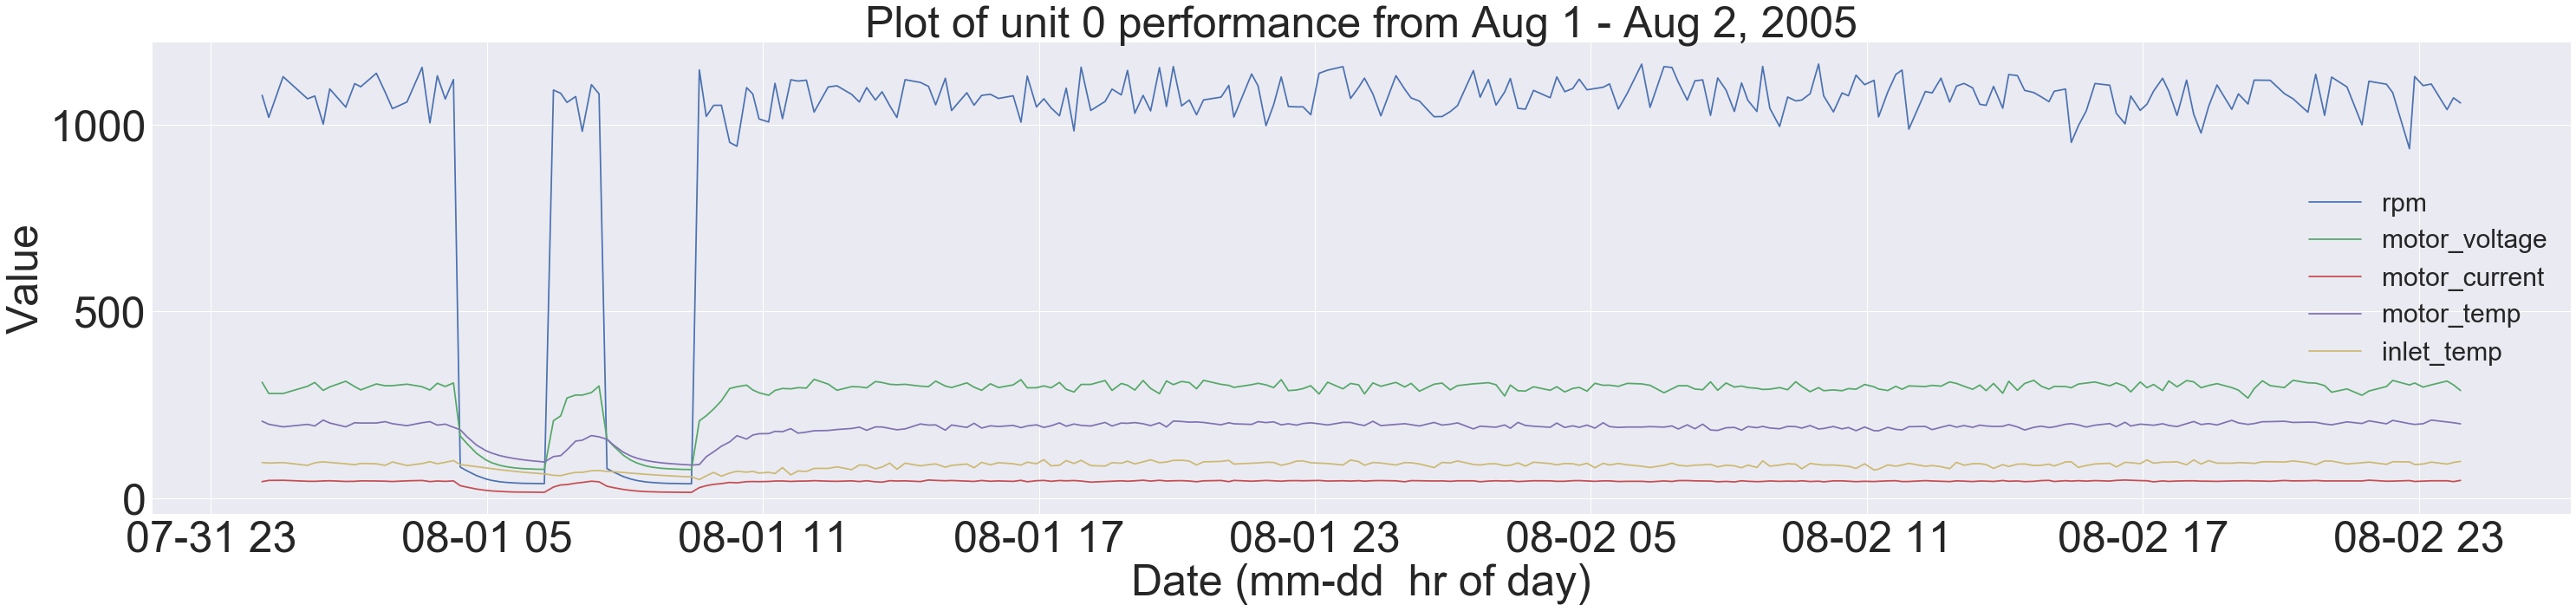

In [19]:
plt.figure(figsize=(50,10))
plt.xlabel('Date (mm-dd  hr of day)',fontsize = 50)
plt.ylabel('Value',fontsize = 50)
plt.title('Plot of unit 0 performance from Aug 1 - Aug 2, 2005', fontsize = 50)
plt.plot(unit0_clean.loc["2005-08-01":"2005-08-02"])
plt.legend(unit0_clean.columns, fontsize = 30)
plt.tick_params(axis = 'both', which = 'major', labelsize = 50)

## Is there a signal that predicts the failure ? ##

As mentioned in the plot above, the drop in the RPM is consis tent across the whole data. The drop in the RPM leads to a drop in all the other metrics as well, which is expected as they are all positively correlated. 

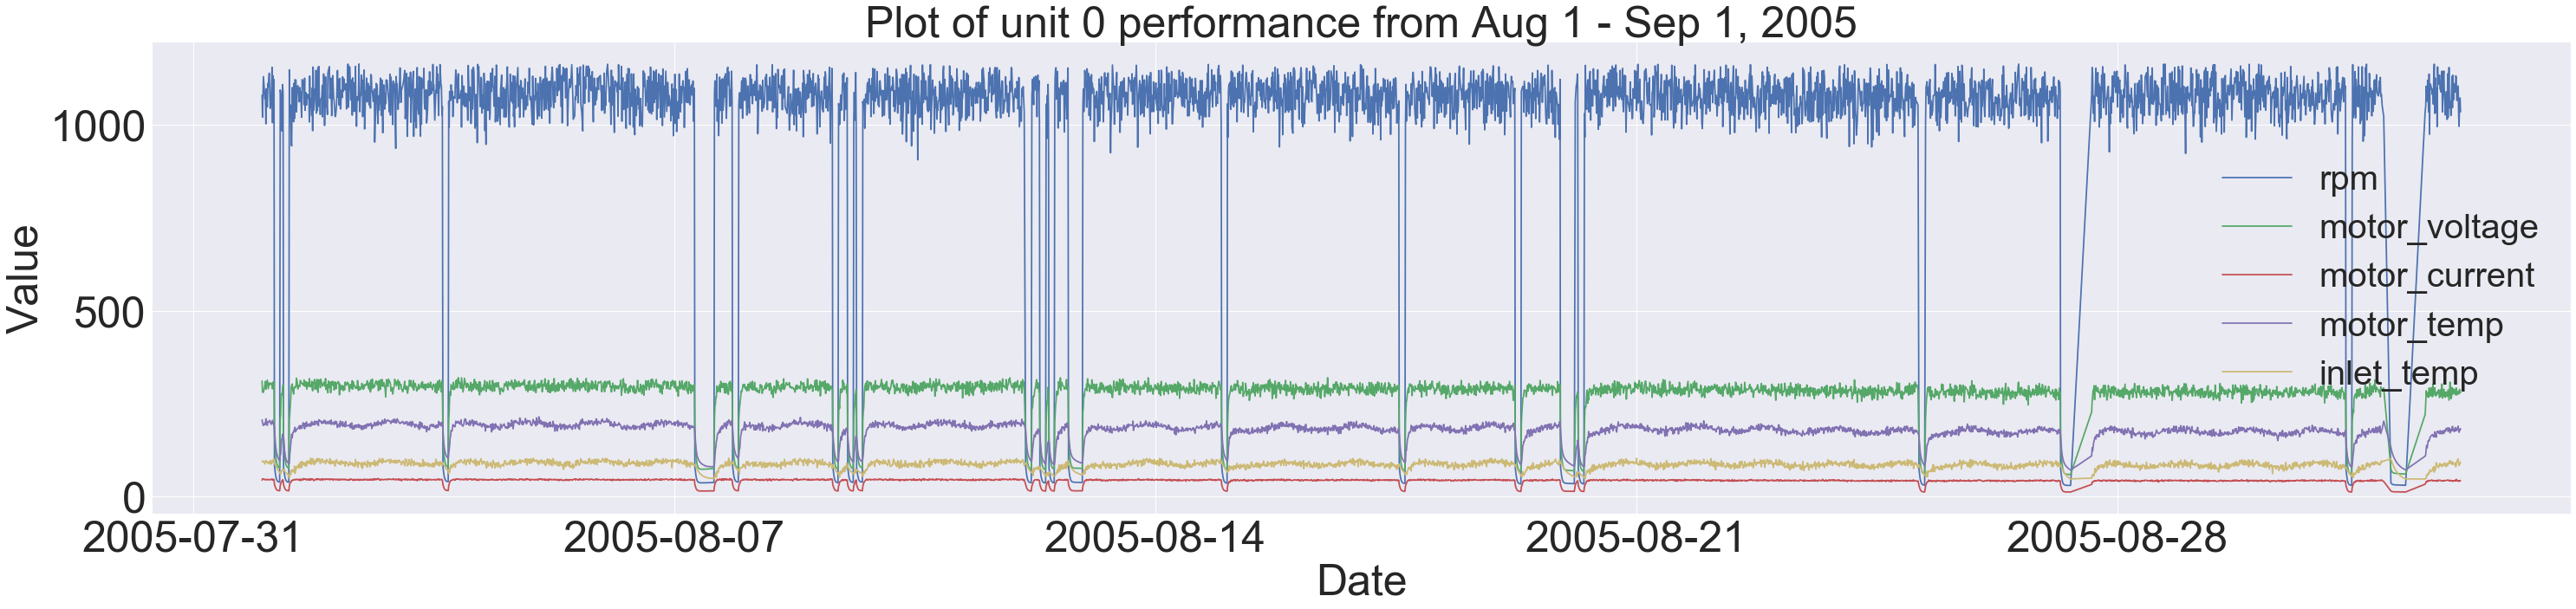

In [20]:
plt.figure(figsize=(50,10))
plt.xlabel('Date',fontsize = 50)
plt.ylabel('Value',fontsize = 50)
plt.title('Plot of unit 0 performance from Aug 1 - Sep 1, 2005', fontsize = 50)
plt.plot(unit0_clean.loc["2005-08-01":"2005-09-01"])
plt.legend(unit0_clean.columns, fontsize = 40)
plt.tick_params(axis = 'both', which = 'major', labelsize = 50)

### Does the data get generated from an independent process? ###

As can be seen from the previous two plots for unit0, the RPM and voltage both show a significant sudden drop suggesting an anomaly in regular behavior. This anomaly can be detected by some sort of a rolling window moving across the time series. Lets try to see the correlations apart from the voltage and RPM by plotting a correlation matrix. This will also give us some insight on if the process that is generating the data is generating it in an independent manner or not. Intuition and domain knowledge suggests that Power = Voltage * Current and higher power will generate higher heat as well, leading to higher temperatures. So we should expect to see some positive correlations. 


In [21]:
unit0_clean.head()

,rpm,motor_voltage,motor_current,motor_temp,inlet_temp
timestamp,,,,,
2003-12-14 05:45:57.604204392,1071.265218,220.091101,29.917097,89.069642,53.178325
2003-12-14 05:57:27.841865348,1121.121953,220.294005,30.317449,91.668490,50.227658
2003-12-14 06:25:18.555832033,1134.563007,216.858225,28.690638,93.489985,47.439531
2003-12-14 06:35:38.064804012,1127.632611,215.315746,29.825574,87.256581,49.198645
2003-12-14 06:55:18.781165507,1059.858213,233.556643,29.929805,95.151337,49.309509


                    rpm  motor_voltage  motor_current  motor_temp  inlet_temp
rpm            1.000000       0.878400       0.754315    0.418630    0.242045
motor_voltage  0.878400       1.000000       0.955580    0.762609    0.576390
motor_current  0.754315       0.955580       1.000000    0.886975    0.709613
motor_temp     0.418630       0.762609       0.886975    1.000000    0.889786
inlet_temp     0.242045       0.576390       0.709613    0.889786    1.000000


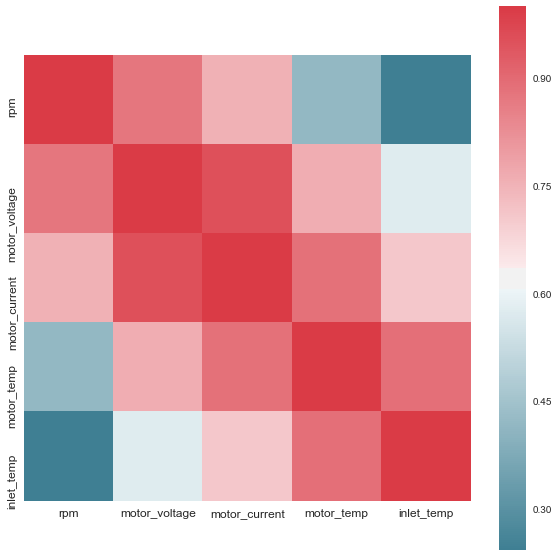

In [22]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 10))
ax.set_xlabel('X_axis',fontsize=20);
ax.set_ylabel('Y_axis',fontsize=20);
corr = unit0_clean.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
labels=['rpm','motor_voltage','motor_current','motor_temp','inlet_temp']
ax.set_xticklabels(labels,fontsize = 12)
ax.set_yticklabels(labels,fontsize = 12)
print(corr)


As can be seen from the correlation plot above, the RPM is highly correlated with motor_voltage and motor_current which was expected. Ohms law, V = IR, is also showing a strong correlation between voltage and current. The motor_temp and inlet_temp also show a stron correlation, which is also expected. I would have expected the RPM and motor_temp to be highly correlated as well but they do not show a strong correlation! 

In [23]:
os.getcwd()

'/Users/suhriddeshmukh/Documents/MIT_Files/PracticeCodes/Tagup/data-science-challenge-master'

## Assembling RMS training data frame ##

In [24]:
rms_data_train = pd.DataFrame()

In [25]:
for root, dirs, files in os.walk(os.path.join(os.getcwd(),'data','train')):
    for file in files:
        if file.endswith("_rms.csv"):
            rms_temp = pd.read_csv(os.path.join(root, file)) 
            rms_temp = clean_data(rms_temp)
            rms_temp.index= pd.to_datetime(rms_temp['timestamp'])
            rms_temp.drop(columns=['timestamp'])
            rms_temp=rms_temp.resample('3H').mean()
            rms_temp['unit_id'] = file[4:8]
            rms_data_train = rms_data_train.append(rms_temp)

In [26]:
rms_data_train.head()

,rpm,motor_voltage,motor_current,motor_temp,inlet_temp,unit_id
timestamp,,,,,,
2004-03-15 03:00:00,1082.281678,227.121736,30.338145,84.282499,41.096890,0001
2004-03-15 06:00:00,1051.033251,222.480230,30.731535,98.306667,52.168941,0001
2004-03-15 09:00:00,1028.199979,224.197195,29.601648,101.709749,57.873196,0001
2004-03-15 12:00:00,1037.652449,221.511800,30.337815,102.537644,58.077009,0001
2004-03-15 15:00:00,1033.399168,222.689312,30.006699,99.751817,54.945244,0001


In [27]:
datetime_df_rms = pd.DataFrame({'Date':rms_data_train.index.map(lambda x: x.strftime('%Y-%m-%d')),
                           'Hour':rms_data_train.index.hour})
datetime_df_rms.head()
date_str= datetime_df_rms.Date.astype('str')
hour_str = datetime_df_rms.Hour.astype('str')

for counter, hour in enumerate(hour_str):
    if len(hour) == 1:
        hour_str[counter] = '0' + hour

date_temp = date_str + ' ' + hour_str
date_temp = date_temp.str.replace('-','')
date_temp = date_temp.str.replace(' ','.')

In [28]:
# Dont run this multiple times
rms_data_train.reset_index(inplace=True)


In [29]:
rms_data_train.head()

,timestamp,rpm,motor_voltage,motor_current,motor_temp,inlet_temp,unit_id
0,2004-03-15 03:00:00,1082.281678,227.121736,30.338145,84.282499,41.096890,0001
1,2004-03-15 06:00:00,1051.033251,222.480230,30.731535,98.306667,52.168941,0001
2,2004-03-15 09:00:00,1028.199979,224.197195,29.601648,101.709749,57.873196,0001
3,2004-03-15 12:00:00,1037.652449,221.511800,30.337815,102.537644,58.077009,0001
4,2004-03-15 15:00:00,1033.399168,222.689312,30.006699,99.751817,54.945244,0001


In [30]:
rms_data_train['unit_id'] = rms_data_train.unit_id.astype('int64')
rms_data_train['timestamp'] = date_temp
rms_data_train.head(10)

,timestamp,rpm,motor_voltage,motor_current,motor_temp,inlet_temp,unit_id
0,20040315.03,1082.281678,227.121736,30.338145,84.282499,41.096890,1
1,20040315.06,1051.033251,222.480230,30.731535,98.306667,52.168941,1
2,20040315.09,1028.199979,224.197195,29.601648,101.709749,57.873196,1
3,20040315.12,1037.652449,221.511800,30.337815,102.537644,58.077009,1
4,20040315.15,1033.399168,222.689312,30.006699,99.751817,54.945244,1
5,20040315.18,1054.070921,220.769027,30.653998,103.212486,58.537457,1
6,20040315.21,1029.968099,224.045660,30.571418,110.046022,63.124160,1
7,20040316.00,1063.232619,223.381344,31.080737,116.611691,63.621964,1
8,20040316.03,1042.562462,228.816882,30.726353,114.453781,67.375115,1
9,20040316.06,1049.596071,224.878039,30.676176,112.684414,64.341561,1


## Assembling Alarms training data frame ##

In [31]:
alarms_data_train=pd.DataFrame()
for root, dirs, files in os.walk(os.path.join(os.getcwd(),'data','train')):
    for file in files:
        if file.endswith("alarms.csv") and os.stat(os.path.join(root, file)).st_size > 0:
            alarms_temp_train = pd.read_csv(os.path.join(root, file),header=None)
            alarms_temp_train['unit_id'] = file[4:8]
            alarms_data_train = alarms_data_train.append(alarms_temp_train)

alarms_data_train.columns = ['timestamp', 'status','unit_id']
alarms_data_train['unit_id'] = alarms_data_train['unit_id'].astype('int64')
alarms_data_train.head()

,timestamp,status,unit_id
0,2004-03-15 03:57:00.089464130,warning,2
1,2004-03-16 12:22:19.354325370,warning,2
2,2004-03-17 00:09:24.874530069,warning,2
3,2004-03-17 05:07:35.777229552,warning,2
4,2004-03-17 05:39:59.374812552,warning,2


In [32]:
alarms_data_train.timestamp = pd.to_datetime(alarms_data_train.timestamp)
alarms_data_train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3039 entries, 0 to 95
Data columns (total 3 columns):
timestamp    3039 non-null datetime64[ns]
status       3039 non-null object
unit_id      3039 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 95.0+ KB


In [33]:
#### RUN THIS COMMAND ONCE AND ONLY ONCE!!!!! ####
alarms_data_train.set_index('timestamp',inplace=True)
#####################################################

In [34]:
alarms_data_train.index.date

array([datetime.date(2004, 3, 15), datetime.date(2004, 3, 16),
       datetime.date(2004, 3, 17), ..., datetime.date(2004, 2, 18),
       datetime.date(2004, 2, 18), datetime.date(2004, 2, 18)],
      dtype=object)

In [35]:
datetime_df_alarms = pd.DataFrame({'Date':alarms_data_train.index.map(lambda x: x.strftime('%Y-%m-%d')),
                                   'Hour':alarms_data_train.index.hour})
datetime_df_alarms.head()
date_str= datetime_df_alarms.Date.astype('str')
hour_str = datetime_df_alarms.Hour.astype('str')


for counter, hour in enumerate(hour_str):
    if len(hour) == 1:
        hour_str[counter] = '0' + hour

date_temp = date_str + ' ' + hour_str
date_temp = date_temp.str.replace('-','')
date_temp = date_temp.str.replace(' ','.')

In [36]:
date_temp.head()

0    20040315.03
1    20040316.12
2    20040317.00
3    20040317.05
4    20040317.05
dtype: object

In [37]:
#### RUN THIS COMMAND ONCE AND ONLY ONCE!!!!! ####
alarms_data_train.reset_index('timestamp',inplace=True)
#####################################################

In [38]:
alarms_data_train.head()

,timestamp,status,unit_id
0,2004-03-15 03:57:00.089464130,warning,2
1,2004-03-16 12:22:19.354325370,warning,2
2,2004-03-17 00:09:24.874530069,warning,2
3,2004-03-17 05:07:35.777229552,warning,2
4,2004-03-17 05:39:59.374812552,warning,2


In [39]:
alarms_data_train.timestamp = date_temp
alarms_data_train.head()

,timestamp,status,unit_id
0,20040315.03,warning,2
1,20040316.12,warning,2
2,20040317.00,warning,2
3,20040317.05,warning,2
4,20040317.05,warning,2


### Merging the alarms data and rms data ###

In [40]:
combined_data_train = rms_data_train.merge(alarms_data_train,on=['timestamp','unit_id'],how='left')
combined_data_train = combined_data_train.fillna('None')
combined_data_train.head(10)

,timestamp,rpm,motor_voltage,motor_current,motor_temp,inlet_temp,unit_id,status
0,20040315.03,1082.28,227.122,30.3381,84.2825,41.0969,1,None
1,20040315.06,1051.03,222.48,30.7315,98.3067,52.1689,1,None
2,20040315.09,1028.2,224.197,29.6016,101.71,57.8732,1,None
3,20040315.12,1037.65,221.512,30.3378,102.538,58.077,1,None
4,20040315.15,1033.4,222.689,30.0067,99.7518,54.9452,1,None
5,20040315.18,1054.07,220.769,30.654,103.212,58.5375,1,None
6,20040315.21,1029.97,224.046,30.5714,110.046,63.1242,1,None
7,20040316.00,1063.23,223.381,31.0807,116.612,63.622,1,None
8,20040316.03,1042.56,228.817,30.7264,114.454,67.3751,1,None
9,20040316.06,1049.6,224.878,30.6762,112.684,64.3416,1,None


In [41]:
combined_data_train.status.unique()

array(['None', 'warning', 'error'], dtype=object)

In [42]:
#combined_data_train.info()
combined_data_train.rpm =  pd.to_numeric(combined_data_train.rpm,errors='ignore')
combined_data_train.motor_temp =  pd.to_numeric(combined_data_train.motor_temp,errors='ignore')

In [43]:
data_train_km = combined_data_train.drop(columns='timestamp')

In [44]:
data_train_km.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55092 entries, 0 to 55091
Data columns (total 7 columns):
rpm              55092 non-null object
motor_voltage    55092 non-null object
motor_current    55092 non-null object
motor_temp       55092 non-null object
inlet_temp       55092 non-null object
unit_id          55092 non-null int64
status           55092 non-null object
dtypes: int64(1), object(6)
memory usage: 3.4+ MB


Lets try to see vizually if it suggents that there should be a  particular number of clusters that the data is grouped into.

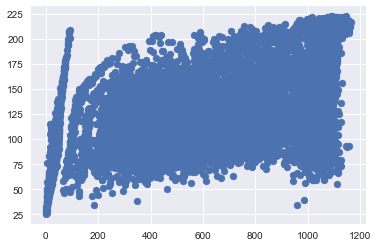

In [45]:
x = data_train_km.rpm.mask(data_train_km.rpm.eq('None')).dropna()
y = data_train_km.motor_temp.mask(data_train_km.motor_temp.eq('None')).dropna()
plt.scatter(x, y)
plt.figure(figsize=(20,20))
plt.show()

In [46]:
data_train_km.head()

,rpm,motor_voltage,motor_current,motor_temp,inlet_temp,unit_id,status
0,1082.28,227.122,30.3381,84.2825,41.0969,1,None
1,1051.03,222.48,30.7315,98.3067,52.1689,1,None
2,1028.2,224.197,29.6016,101.71,57.8732,1,None
3,1037.65,221.512,30.3378,102.538,58.077,1,None
4,1033.4,222.689,30.0067,99.7518,54.9452,1,None


## Does it cluster well? ##

Let us see if the data can be divided into certain groups. Data suggests that high temperature, high voltage, high current and high RPM should be one group and the lower values of these parameters should be clustered into a separate group. We will use k-means clustering to vizualize the clusters. 

In [47]:
data_train_km_without_status = data_train_km.iloc[:,:-2]
data_train_km_without_status =  data_train_km_without_status.mask(data_train_km_without_status.eq('None')).dropna()
data_train_km_without_status.apply(pd.to_numeric)
data_train_km_without_status = data_train_km_without_status.apply(lambda x: x.astype(float))
data_train_km_without_status.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52511 entries, 0 to 55091
Data columns (total 5 columns):
rpm              52511 non-null float64
motor_voltage    52511 non-null float64
motor_current    52511 non-null float64
motor_temp       52511 non-null float64
inlet_temp       52511 non-null float64
dtypes: float64(5)
memory usage: 2.4 MB


In [48]:
data_train_km_std = stats.zscore(data_train_km_without_status)

kmeans = KMeans(n_clusters=2, random_state=0).fit(data_train_km_std)
labels = kmeans.labels_

data_train_km_without_status['clusters'] = labels
columns = ['rpm', 'motor_voltage','motor_current','motor_temp','inlet_temp']
columns.extend(['clusters'])


In [49]:
print (data_train_km_without_status[columns].groupby(['clusters']).mean())

                  rpm  motor_voltage  motor_current  motor_temp  inlet_temp
clusters                                                                   
0          865.532454     207.029479      30.043818  116.348329   64.139680
1         1069.819723     288.638447      44.017350  185.498882   86.989491


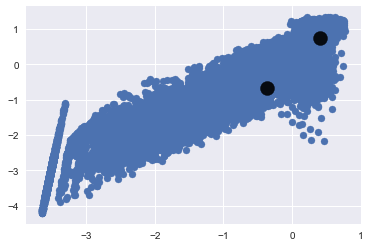

In [50]:
plt.scatter(data_train_km_std[:, 0], data_train_km_std[:, 1])

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.9);

As can be seen from the above plot, there are clearly two main clusters in the data, one where the RPM range is around 1000RPM with the corresponding remaining values, and one where the RPM is 800 with the corresponding remaining values. This suggests that the data does cluster into two groups reasonably well. The following figure also shows the "elbow method" for choosing the right k in k means clustering. From the elbow plot as well, we can see that there is an elbow at k = 2 or k = 3. This also suggests that 2 clusters is mostly appropriate to cluster the data. 

There is a striking similarity of the k means plot with the earlier plot of RPM vs. motor_temp, and there are some cases where the motor_temp is high even when the RPM is low. This situtaion needs to be investigated further. 

### Predicting the number of clusters, k, using the elbow method ###

In [51]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(data_train_km_std)
    kmeanModel.fit(data_train_km_std)
    distortions.append(sum(np.min(cdist(data_train_km_std, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / data_train_km_std.shape[0])



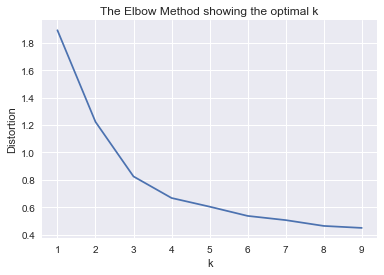

In [52]:
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')

plt.show()

As can be seen from the elbow method, we get a significant drop in the distortion going from 1 to 2 clusters, and not so significant drop going from 2 to 3. We don't gain much going from k>3. Therefore, the ideal number of clusters could be 2 or three. To prevent overfitting, k = 2 was chosen as the correct number of clusters. It can be seen by modifying the code by setting k = 3 that, from the three clusters that we get, two turn out to be very close to each other. 

## What size window is needed to make an accurate forecast? ##

In order to select a proper window size for generating a forecast, k means clustering was used to cluster a certain amount of data into appropriate clusters. Data for a single unit was explored and a "sliding window" across time was considered. The data within this sliding window was then reproduced using k means clustering algorithm. It was found that given the data for unit0 a sliding length of 16 data points or approximately three hours was used. The reconstructed data using a sliding window of 3 hours is shown further below in the notebook.

In [53]:
unit0_clean.head(16)

,rpm,motor_voltage,motor_current,motor_temp,inlet_temp
timestamp,,,,,
2003-12-14 05:45:57.604204392,1071.265218,220.091101,29.917097,89.069642,53.178325
2003-12-14 05:57:27.841865348,1121.121953,220.294005,30.317449,91.668490,50.227658
2003-12-14 06:25:18.555832033,1134.563007,216.858225,28.690638,93.489985,47.439531
2003-12-14 06:35:38.064804012,1127.632611,215.315746,29.825574,87.256581,49.198645
2003-12-14 06:55:18.781165507,1059.858213,233.556643,29.929805,95.151337,49.309509
2003-12-14 07:27:46.752583072,1124.904096,234.884811,30.620366,102.245957,48.517268
2003-12-14 07:44:15.742194305,1003.834100,211.951401,30.950529,97.387215,55.314958
2003-12-14 07:56:08.921987820,1094.671535,213.689933,30.103958,99.299773,55.186753
2003-12-14 08:05:07.743356163,1036.315022,208.416372,29.946055,99.930796,52.484851


In [54]:
unit0_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 71407 entries, 2003-12-14 05:45:57.604204392 to 2005-09-10 17:36:47.236452969
Data columns (total 5 columns):
rpm              71407 non-null float64
motor_voltage    71407 non-null float64
motor_current    71407 non-null float64
motor_temp       71407 non-null float64
inlet_temp       71407 non-null float64
dtypes: float64(5)
memory usage: 5.8 MB


Below is the RPM plotted for unit0 for an entire day of August $1^{st}$ 2005. And as we can see, right about 4am - 6am and from 7 - 8 am the RPM drops to less than 250 when the expected historical data suggests that it should be somewhere around 1100. This suggests a cause for some further innvestigation. Also, this gives us a suggestion that the window size should be in terms of hours and not days or weeks. This intuitively makes sense becuase if we are monitoring equipment that is supposed to run almost continuously, it makes sense to keep a check on it every few hours. Therefore, data for one day will be analyzed for unit0 to check for a reasonable forecasting model. This process should be done for each of the units in the training and the testing folders separately. For the sake of time, this notebook only explores the modeling process for unit 0. 

Below is a plot showing the performance of unit 0 on August $1^{st}$,2005. As can be seen between 4am - 9am, theres a significant departure from normal behavior in the RPM (and other variables, which are correlated).

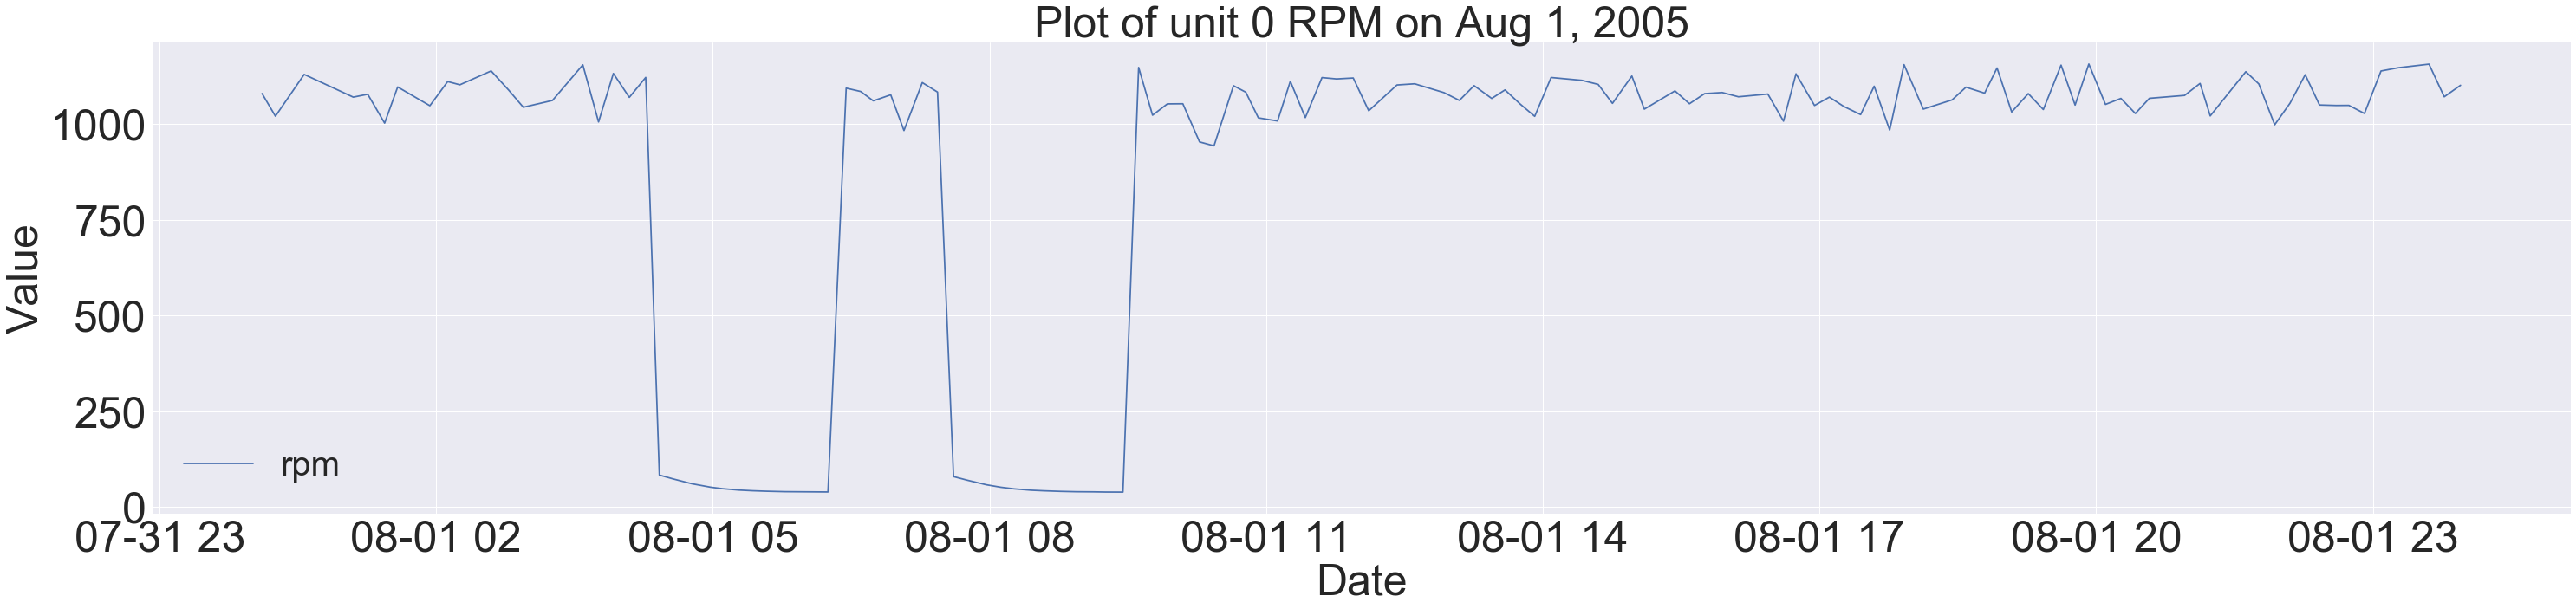

In [55]:
plt.figure(figsize=(50,10))
plt.xlabel('Date',fontsize = 50)
plt.ylabel('Value',fontsize = 50)
plt.title('Plot of unit 0 RPM on Aug 1, 2005', fontsize = 50)
plt.plot(unit0_clean.loc["2005-08-01":"2005-08-01"]['rpm'])
#plt.plot(unit0_clean.loc[:]['rpm'])
plt.legend(unit0_clean.columns, fontsize = 40)
plt.tick_params(axis = 'both', which = 'major', labelsize = 50)

## Anomaly detection using k means clustering sliding window ##

A more detailed description of using k means clustering for anomaly detection of time-series data is given here:
http://amid.fish/anomaly-detection-with-k-means-clustering.

At a very high level, our algorithm will be:

Training:
- Split waveform data into segments of n samples
- Form a space in n dimensions, with each segment representing one point
- Determine clustering of segment points, and determine the centres or centroids of the clusters
- Cluster centroids provide library of "normal" waveform shapes 

Testing:

- Try to reconstruct waveform data to be tested using cluster centroids learned during training
- Poor reconstruction error on any individual segment indicates anomalous shape

Particularly, what is done in this algorithm is the following. The k-means algorithm was trained on the "correct" behavior of motor RPM. So the k-means algorithm leanrt the corrent shape of the RPM (basically an almost flat,rugged line). The waveform for the RPM that was chosen for training was chosen such that it had no dips in the RPM and was showing correct behavior for RPM. Next, these learnt shapes were stored and a new waveform for RPM was reconstructed from the original waveform using these learnt shapes. The reconstructed waveform for the RPM, if reporduced correctly should show no spikes in the error. If the error shows a spike, that means a failure might have occured. 

In [56]:
df_ts = pd.DataFrame(unit0_clean.loc["2005-08-04":"2005-08-06"]['rpm'])
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 394 entries, 2005-08-04 00:06:33.889479489 to 2005-08-06 23:55:35.791992389
Data columns (total 1 columns):
rpm    394 non-null float64
dtypes: float64(1)
memory usage: 6.2 KB


In [57]:
df_ts.head(10)

,rpm
timestamp,
2005-08-04 00:06:33.889479489,1159.222124
2005-08-04 00:26:39.153617700,1069.132620
2005-08-04 00:35:10.850848909,1064.668850
2005-08-04 00:45:09.050300662,1101.129837
2005-08-04 00:56:12.956177138,1025.432268
2005-08-04 01:04:56.712680318,1003.248330
2005-08-04 01:15:40.851574244,1028.474075
2005-08-04 01:27:09.066298320,1148.234098
2005-08-04 01:36:13.558721940,1042.220629


### Windowing: Selecting the right sliding window, 16 data points were chosen in this case ###

The first step in our process is to split the waveform into overlapping segments, with the section of the original data sampled sliding along by two samples each time. We take this approach so that we get instances of each waveform shape with a variety of horizontal translations.

In [58]:
segment_len = 16
slide_len = 1
y = df_ts.rpm
segments = []
for start_pos in range(0, len(y), slide_len):
    end_pos = start_pos + segment_len
    # make a copy so changes to 'segments' doesn't modify the original ekg_data
    segment = np.copy(y[start_pos:end_pos])
    # if we're at the end and we've got a truncated segment, drop it
    if len(segment) != segment_len:
        continue
    segments.append(segment)

print("Produced %d waveform segments" % len(segments))

Produced 379 waveform segments


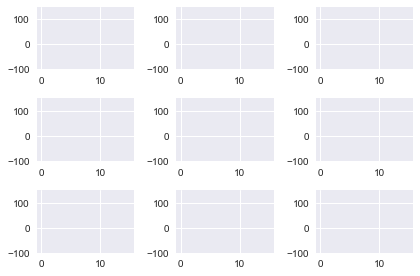

In [59]:
plot_waves(segments, step=3)

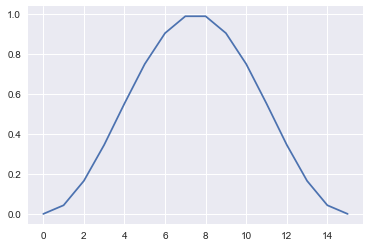

In [60]:
window_rads = np.linspace(0, np.pi, segment_len)
window = np.sin(window_rads)**2
plt.plot(window)
plt.show()

In [61]:
windowed_segments = []
for segment in segments:
    windowed_segment = np.copy(segment) * window
    windowed_segments.append(windowed_segment)

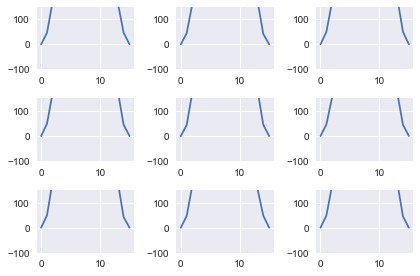

In [62]:
plot_waves(windowed_segments, step=3)

### Clustering ###

Next, we cluster our waveform segments in n-dimensional space where n is the number of different segment shapes our algorithm learned. The k-means algorithm is provided by Python's scikit-learn library.

In [63]:
clusterer = KMeans(n_clusters=len(segments))
clusterer.fit(windowed_segments)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=379, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

The cluster centroids are available through the cluster_centers attribute. Let's take a look to see what sort of shapes it's learned:

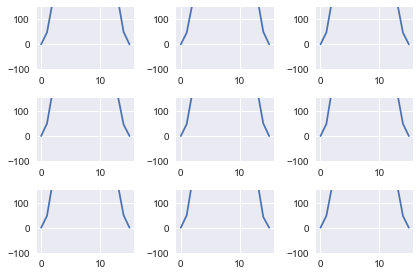

In [64]:
plot_waves(clusterer.cluster_centers_, step=3)

### Reconstruction from Clusters ###

Finally, we reconstrt our waveform to be tested using the learned library of shapes. Our approach is going to be very simple. We'll:

- Split the data into overlapping segments
- Find the cluster centroid which best matches our segment
- Use that centroid as the reconstruction for that segment
- Join the reconstruction segments up to form the reconstruction

This time, we only need enough overlap between segments to allow us to stitch the reconstructions back together again, so we'll go with an overlap of half a segment.

First, let's see how well we do at reconstructing the original waveform. We first form segments:


In [65]:
slide_len = segment_len/2
slide_len= int(slide_len)
slide_len

8

In [66]:
test_segments = sliding_chunker(y,window_len=segment_len,slide_len=slide_len)

Before trying to reconstruct the whole thing, we can check how the reconstruction fares for individual segments.

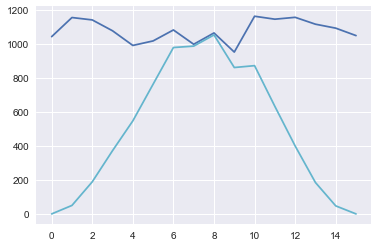

In [67]:
centroids = clusterer.cluster_centers_

segment = np.copy(test_segments[1])
# remember, the clustering was set up using the windowed data
# so to find a match, we should also window our search key
windowed_segment = segment * window
# predict() returns a list of centres to cope with the possibility of multiple
# samples being passed
windowed_segment = windowed_segment.reshape(1,-1)
nearest_centroid_idx = clusterer.predict(windowed_segment)[0]
nearest_centroid = np.copy(centroids[nearest_centroid_idx])

plt.figure()
plt.plot(segment, label="Original segment")
plt.plot(windowed_segment, label="Windowed segment")
plt.plot(nearest_centroid, label="Nearest centroid")
#plt.legend()
plt.show()

As can be seen from the above figure, the reconstructed waveform is shown in light blue and the original RPM is shown in dark blue. The reconstructed waveform is not perfect, but because in re-creating the signal we will be using a significant overlap anyway, we will go ahead with this reconstructed waveform. 

In [68]:
reconstruction = np.zeros(len(y))
slide_len = segment_len/2

In [69]:
for segment_n, segment in enumerate(test_segments):
    # don't modify the data in segments
    segment = np.copy(segment)
    segment *= window
    segment = segment.reshape(1,-1)
    nearest_centroid_idx = clusterer.predict(segment)[0]
    centroids = clusterer.cluster_centers_
    nearest_centroid = np.copy(centroids[nearest_centroid_idx])
    
    # overlay our reconstructed segments with an overlap of half a segment
    pos = int(segment_n * slide_len)
    reconstruction[pos:pos+segment_len] += nearest_centroid



In [70]:
n_plot_samples = 300
error = reconstruction[0:n_plot_samples] - y[0:n_plot_samples]
error_98th_percentile = np.percentile(error, 98)
print("Maximum reconstruction error was %.1f" % error.max())
print("98th percentile of reconstruction error was %.1f" % error_98th_percentile)

Maximum reconstruction error was -10.7
98th percentile of reconstruction error was -11.0


In [71]:
len(reconstruction)

394

In [72]:
x_index = np.linspace(0,len(reconstruction)-1,len(reconstruction))
len(x_index)


394

In [73]:
x_index = x_index.astype(int)


In [74]:
plotting_df = pd.DataFrame({'x':x_index[0:n_plot_samples], 'original_RPM': y.values[0:n_plot_samples],'reconstructed_RPM':reconstruction[0:n_plot_samples],'error':error})
plotting_df.head()
#plotting_df = plotting_df.reset_index()
plotting_df.drop(['x'],axis=1,inplace=True)
plotting_df.head()

,error,original_RPM,reconstructed_RPM
timestamp,,,
2005-08-04 00:06:33.889479489,-1159.222124,1159.222124,0.000000
2005-08-04 00:26:39.153617700,-1022.916934,1069.132620,46.215686
2005-08-04 00:35:10.850848909,-888.535682,1064.668850,176.133168
2005-08-04 00:45:09.050300662,-720.698835,1101.129837,380.431002
2005-08-04 00:56:12.956177138,-459.122704,1025.432268,566.309564


### Reconstructed waveform for RPM for unit0 ###

As can be seen from the figure below, using the k-means clustering and sliding window technique, we were able to reconstruct the original wave form accurate to the point where the trend is consistent, if not the magnitude. If there was more time, the next step would have been to optimize the error even further, but for our purpose of anomaly detection this will suffice. 

Text(0.5,1,'Correct behavior of RPM of unit 0')

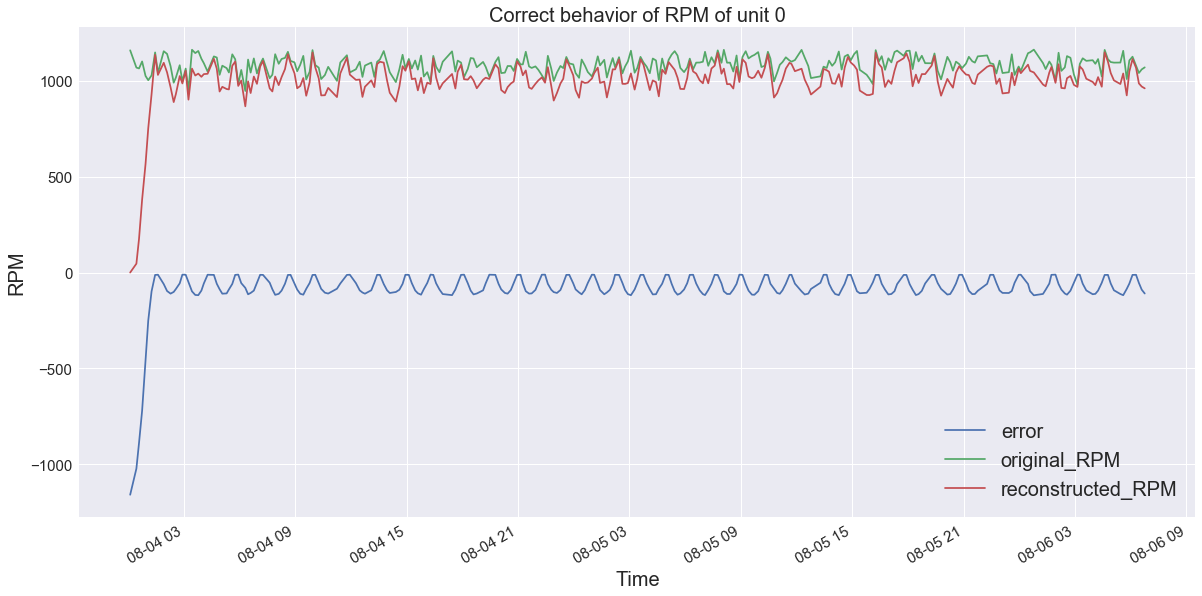

In [75]:
ts_plot = plotting_df.plot(figsize = (20,10), fontsize=20)
ts_plot.legend(loc=4, prop={'size': 20})
plt.xlabel('Time', fontsize=20)
plt.ylabel('RPM', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.title('Correct behavior of RPM of unit 0',fontsize = 20)

### Anomaly Detection ###

Now that we're confident in our reconstruction algorithm, let's see what happens when we have an anomalous waveform in the RPM. We will use the data for unit0 on August 1st, 2005. We know it showed two dips in the RPM indicating a possible failure. 

In [76]:
anomalous_data = unit0_clean.loc["2005-08-01":"2005-08-01"]['rpm'].values

In [77]:
reconstruct(anomalous_data.reshape(1,-1), window, clusterer)

array([0.])

In [78]:
n_plot_samples = 128
error = reconstruction[0:n_plot_samples] - anomalous_data[0:n_plot_samples]
error_98th_percentile = np.percentile(error, 98)
print("Maximum reconstruction error was %.1f" % error.max())
print("98th percentile of reconstruction error was %.1f" % error_98th_percentile)


Maximum reconstruction error was 1099.9
98th percentile of reconstruction error was 1049.8


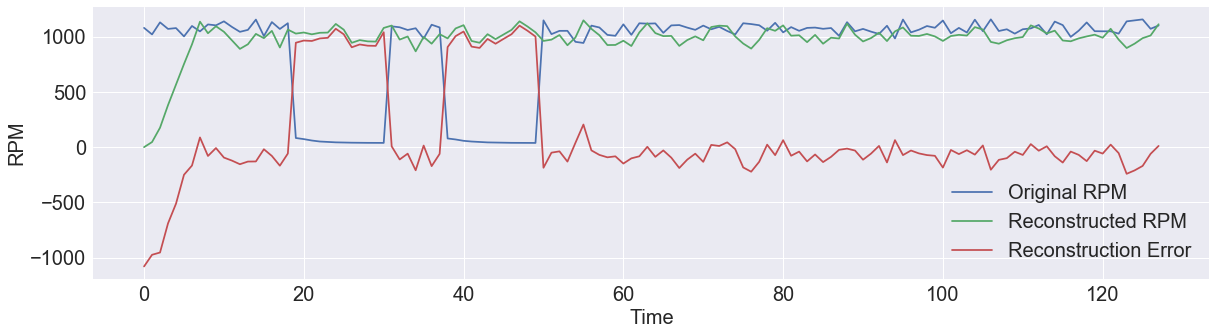

In [79]:
plt.figure(figsize=(20,5))
plt.xlabel('Time',fontsize = 20)
plt.ylabel('RPM',fontsize = 20)
plt.plot(anomalous_data[0:n_plot_samples], label="Original RPM")
plt.plot(reconstruction[0:n_plot_samples], label="Reconstructed RPM")
plt.tick_params(axis='both', which='major', labelsize=20)
plt.plot(error[0:n_plot_samples], label="Reconstruction Error")
plt.legend(loc=4, prop={'size': 20})
plt.show()

As can be seen from the figure above, the error curve which should have been hovering around 0 show two spikes corressponding exactly at the location where the RPM drops to near 0. Since our anomaly has produced a shape in the waveform that hadn't been seen before, the waveform around that point couldn't be reconstructed using the learned shape library. This gives a large, easily visible reconstruction error! This error could be easily detected using a simple threshold detector.

This problem could have been solved in different ways. For example, we could have trained a predictive neural network model, and examined the difference between the predicted waveform and the actual waveform. In general, there is no 'one size fits all' solution in machine learning - different techniques will be required for different problems.

Finally, lets look at the entire data provided for training and testing, and see if we can classify the units that had error, warning or were functing fine. We will use Gradient boosting method, which is essentially provided in the XGboost package from python. 

## Assembling the training and testing data set for gradient boosting classifier using XGboost 

In [80]:
combined_data_train.head()

,timestamp,rpm,motor_voltage,motor_current,motor_temp,inlet_temp,unit_id,status
0,20040315.03,1082.28,227.122,30.3381,84.2825,41.0969,1,None
1,20040315.06,1051.03,222.48,30.7315,98.3067,52.1689,1,None
2,20040315.09,1028.2,224.197,29.6016,101.71,57.8732,1,None
3,20040315.12,1037.65,221.512,30.3378,102.538,58.077,1,None
4,20040315.15,1033.4,222.689,30.0067,99.7518,54.9452,1,None


In [81]:
X_train = combined_data_train[['rpm', 'motor_voltage','motor_current','motor_temp', 'inlet_temp']]
X_train.head()

,rpm,motor_voltage,motor_current,motor_temp,inlet_temp
0,1082.28,227.122,30.3381,84.2825,41.0969
1,1051.03,222.48,30.7315,98.3067,52.1689
2,1028.2,224.197,29.6016,101.71,57.8732
3,1037.65,221.512,30.3378,102.538,58.077
4,1033.4,222.689,30.0067,99.7518,54.9452


In [82]:
y_train  = combined_data_train['status']
y_train.head()

0    None
1    None
2    None
3    None
4    None
Name: status, dtype: object

### Assemble X and y matrix for the test data ###

### Assemble rms test data ###

In [83]:
os.getcwd()
rms_data_test = pd.DataFrame()
for root, dirs, files in os.walk(os.path.join(os.getcwd(),'data','test')):
    for file in files:
        if file.endswith("_rms.csv"):
            rms_temp_test = pd.read_csv(os.path.join(root, file)) 
            rms_temp_test = clean_data(rms_temp_test)
            rms_temp_test.index= pd.to_datetime(rms_temp_test['timestamp'])
            rms_temp_test.drop(columns=['timestamp'])
            rms_temp_test=rms_temp_test.resample('3H').mean()
            rms_temp_test['unit_id'] = file[4:8]
            rms_data_test = rms_data_test.append(rms_temp_test)

rms_data_test.reset_index(inplace=True)
rms_data_test = rms_data_test.loc[-rms_data_test['rpm'].isnull()]
dates = rms_data_test['timestamp'].unique()
rms_data_test['unit_id'] = rms_data_test['unit_id'].astype('int64')
rms_data_test['timestamp'] = rms_data_test['timestamp'].astype('str')
rms_data_test['timestamp']= rms_data_test['timestamp'].str.split(':').str.get(0)
rms_data_test['timestamp']=rms_data_test['timestamp'].str.replace('-','')
rms_data_test['timestamp']=rms_data_test['timestamp'].str.replace(' ','.')
rms_data_test['timestamp'] = rms_data_test['timestamp'].astype(np.dtype(decimal.Decimal))

rms_data_test.head()

,timestamp,rpm,motor_voltage,motor_current,motor_temp,inlet_temp,unit_id
0,20180501.00,1062.479294,262.766127,35.919145,108.399277,44.286141,27
1,20180501.03,1071.435592,264.104036,39.621782,140.357896,65.142288,27
2,20180501.06,1043.681864,254.047326,36.862176,140.826154,70.979619,27
3,20180501.09,1056.773559,244.249937,35.334770,128.877762,69.227453,27
4,20180501.12,744.834099,193.491494,29.557811,116.496169,64.484809,27


In [84]:
#datetime_df_rms_test = pd.DataFrame({'Date':rms_data_test.index.map(lambda x: x.strftime('%Y-%m-%d')),
#                           'Hour':rms_data_test.index.hour})
#datetime_df_rms.head()
#date_str= datetime_df_rms.Date.astype('str')
#hour_str = datetime_df_rms.Hour.astype('str')

#for counter, hour in enumerate(hour_str):
#    if len(hour) == 1:
#        hour_str[counter] = '0' + hour

#date_temp = date_str + ' ' + hour_str
#date_temp = date_temp.str.replace('-','')
#date_temp = date_temp.str.replace(' ','.')


In [85]:
# Dont run this multiple times
# rms_data_test.reset_index(inplace=True)

In [86]:
#rms_data_test['unit_id'] = rms_data_test.unit_id.astype('int64')
#rms_data_test['timestamp'] = date_temp
#rms_data_test.head(10)

### Alarms test data ####

In [87]:
alarms_data_test=pd.DataFrame()
for root, dirs, files in os.walk(os.path.join(os.getcwd(),'data','test')):
    for file in files:
        if file.endswith("alarms.csv") and os.stat(os.path.join(root, file)).st_size > 0:
            alarms_temp_test = pd.read_csv(os.path.join(root, file),header=None)
            alarms_temp_test['unit_id'] = file[4:8]
            alarms_data_test = alarms_data_test.append(alarms_temp_test)
alarms_data_test.columns = ['timestamp', 'status','unit_id']
alarms_data_test['unit_id'] = alarms_data_test['unit_id'].astype('int64')
alarms_data_test['timestamp'] = alarms_data_test['timestamp'].str.split('.').str.get(0)
alarms_data_test['timestamp'] = alarms_data_test['timestamp'].str.split(':').str.get(0)
alarms_data_test['timestamp'] = alarms_data_test['timestamp'].str.replace('-','')
alarms_data_test['timestamp'] = alarms_data_test['timestamp'].str.replace(' ','.')
alarms_data_test['timestamp'] = alarms_data_test['timestamp'].astype(np.dtype(decimal.Decimal))

alarms_data_test.head()
#alarms_data_test.columns = ['timestamp', 'status','unit_id']
#alarms_data_test['unit_id'] = alarms_data_test['unit_id'].astype('int64')
#alarms_data_test.head()

,timestamp,status,unit_id
0,20180503.05,warning,29
1,20180505.21,warning,29
2,20180518.01,warning,29
3,20180523.15,warning,29
4,20180523.22,warning,29


In [88]:
#### RUN THIS COMMAND ONCE AND ONLY ONCE!!!!! ####
#alarms_data_test.set_index('timestamp',inplace=True)
#####################################################

In [89]:
#alarms_data_test.index.date[0:10]

In [90]:
#datetime_df_alarms_test = pd.DataFrame({'Date':alarms_data_test.index.map(lambda x: x.strftime('%Y-%m-%d')),
#                                   'Hour':alarms_data_test.index.hour})
#datetime_df_alarms_test.head()
#date_str = datetime_df_alarms_test.Date.astype('str')
#hour_str = datetime_df_alarms_test.Hour.astype('str')


#for counter, hour in enumerate(hour_str):
#    if len(hour) == 1:
#        hour_str[counter] = '0' + hour

#date_temp = date_str + ' ' + hour_str
#date_temp = date_temp.str.replace('-','')
#date_temp = date_temp.str.replace(' ','.')

In [91]:
#date_temp.head()

In [92]:
#### RUN THIS COMMAND ONCE AND ONLY ONCE!!!!! ####
#alarms_data_test.reset_index('timestamp',inplace=True)
#####################################################

In [93]:
#alarms_data_test.head()

In [94]:
#alarms_data_test.timestamp = date_temp
#alarms_data_test.head()

### Merging the alarms test data and rms test data ###

In [95]:
combined_data_test = rms_data_test.merge(alarms_data_test,on=['timestamp','unit_id'],how='left')
combined_data_test = combined_data_test.fillna('None')
combined_data_test.head()

,timestamp,rpm,motor_voltage,motor_current,motor_temp,inlet_temp,unit_id,status
0,20180501.00,1062.479294,262.766127,35.919145,108.399277,44.286141,27,None
1,20180501.03,1071.435592,264.104036,39.621782,140.357896,65.142288,27,None
2,20180501.06,1043.681864,254.047326,36.862176,140.826154,70.979619,27,None
3,20180501.09,1056.773559,244.249937,35.334770,128.877762,69.227453,27,None
4,20180501.12,744.834099,193.491494,29.557811,116.496169,64.484809,27,None


In [96]:
combined_data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6890 entries, 0 to 6889
Data columns (total 8 columns):
timestamp        6890 non-null object
rpm              6890 non-null float64
motor_voltage    6890 non-null float64
motor_current    6890 non-null float64
motor_temp       6890 non-null float64
inlet_temp       6890 non-null float64
unit_id          6890 non-null int64
status           6890 non-null object
dtypes: float64(5), int64(1), object(2)
memory usage: 484.5+ KB


In [97]:
combined_data_test.status.unique()

array(['None', 'warning', 'error'], dtype=object)

In [98]:
X_train_xgb = combined_data_train[['rpm','motor_voltage','motor_current','motor_temp','inlet_temp']]
X_train_xgb.replace('None', 0, inplace=True)
X_train_xgb.replace('warning', 1, inplace=True)
X_train_xgb.replace('error', 2, inplace=True)
X_train_xgb = X_train_xgb.as_matrix()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [99]:

y_train_xgb = combined_data_train[['status']]
y_train_xgb.loc[(y_train_xgb.status == 'None')] = 0
y_train_xgb.loc[(y_train_xgb.status == 'warning')] = 1
y_train_xgb.loc[(y_train_xgb.status == 'error')] = 2
y_train_xgb = y_train_xgb.as_matrix()

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.p

In [100]:
type(X_train_xgb)
type(y_train_xgb)

numpy.ndarray

### Test Matrix ###

In [101]:
X_test_xgb = combined_data_test[['rpm','motor_voltage','motor_current','motor_temp','inlet_temp']]
X_test_xgb.replace('None', 0, inplace=True)
X_test_xgb.replace('warning', 1, inplace=True)
X_test_xgb.replace('error', 2, inplace=True)
X_test_xgb = X_test_xgb.as_matrix()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [102]:

y_test_xgb = combined_data_test[['status']]
y_test_xgb.loc[(y_test_xgb.status == 'None')] = 0
y_test_xgb.loc[(y_test_xgb.status == 'warning')] = 1
y_test_xgb.loc[(y_test_xgb.status == 'error')] = 2
y_test_xgb = y_test_xgb.as_matrix()

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.p

In [103]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train_xgb, label= y_train_xgb)
dtest  = xgb.DMatrix(X_test_xgb, label=y_test_xgb)

In [104]:
param = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 3}  # the number of classes that exist in this datset
num_round = 20  # the number of training iterations

In [105]:
bst = xgb.train(param, dtrain, num_round)

In [106]:
preds = bst.predict(dtest)

In [107]:
import numpy as np
best_preds = np.asarray([np.argmax(line) for line in preds])

### Evaluating the results from the model ###

Accuracy = 98.0%

Precision = 32.7% 

Recall = 33.3 % 

In [108]:
from sklearn.metrics import precision_score,recall_score,accuracy_score
print('Accuracy:',accuracy_score(y_test_xgb, best_preds))
print('Precision:',precision_score(y_test_xgb, best_preds, average='macro'))
print('Recall:',recall_score(y_test_xgb, best_preds, average='macro'))

Accuracy: 0.9801161103047895
Precision: 0.32675279430976917
Recall: 0.33328397986378444


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


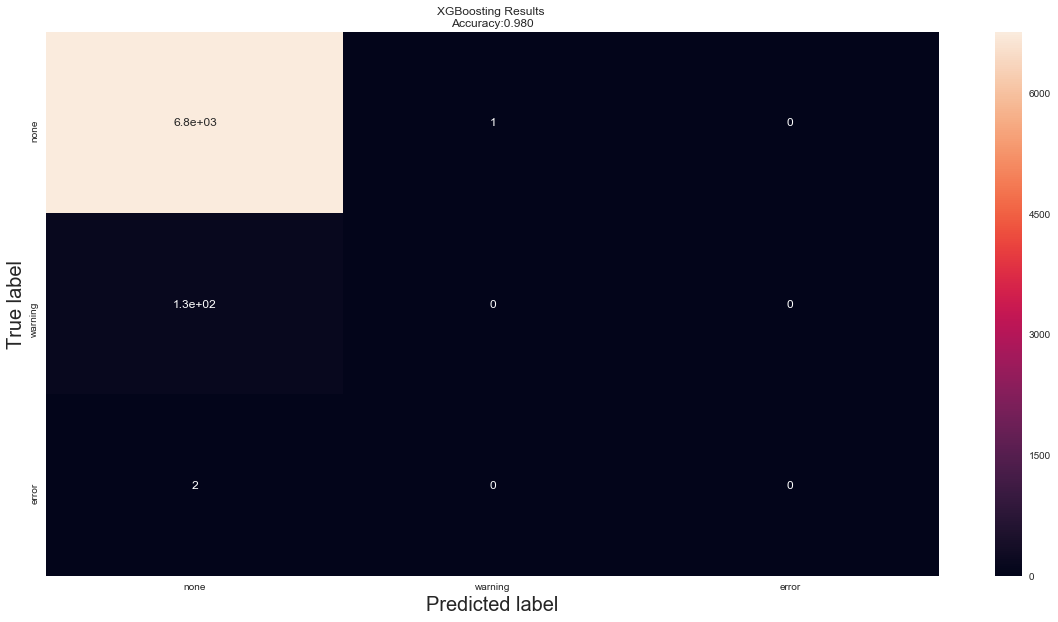

In [109]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
cm = confusion_matrix(y_test_xgb, best_preds) 
plt.figure(figsize=(20,10))
cm_df = pd.DataFrame(cm,
                     index = ['none','warning','error'], 
                     columns = ['none','warning','error'])
sns.heatmap(cm_df, annot=True)
plt.title('XGBoosting Results \nAccuracy:{0:.3f}'.format(accuracy_score(y_test_xgb, best_preds)))
plt.ylabel('True label',fontsize = 20)
plt.xlabel('Predicted label',fontsize = 20)
plt.show()

As can be seen from the confusion matrix, because the data set had mostly non lables, the none-none prediction was the highest number of classifications. There quite a few "warnings" that were not detected correctly. The data set only had two "errors" so it is not very conclusive to say if it can detect errors correctly or not. 

A few things to note about the XGboost algorithm are the following. This algorithm, or any other machine learning classification algorithm in this particular data set where the data is so biased towards just one type of class is going to have difficulty predicting any other class. This is because there is not enough fault data for the algorithm to learn the faulty behavior. Therefore some re-sampling of the faulty data in this case might be warrented to artificially increase the faulty data sample. But that would also mean re-sampling RPM, voltage and other associated parameters which requires domain knowledge and modeling of the physical process of the system. Therefore XGboost or other classification techniques might not work best for our particular problem. 

A more suitable and promising solution could be the timeseries based anomaly detection method mentioned earlier to predict failure. The method was not particularly predictive as we had to use the original waveform to get the reconstructed waveform for the RPM, but it was atleast more robust in detecting the outliers.

## Conclusion ##

#### Does it show meaningful clustering? Do the observations appear independent?####

As can be seen from the earlier plots, the data does show meaningful clustering for k=2. We see two distinct clusters, one where the RPM is 1100 (and other corressponding values) and one with RPM of 850. We can also see from the "elbow method" that as we try to divide the data into more clusters, the gain diminishes pretty quickly after k>2. This can be seen from the "elbow plot" and also by modifying the value of k in the algorithm and plotting the cluster centroids. Even for k =3, two of the cluster centroids are very close to each other suggessting that they are very similar clusters. 

The observations do not appear entirely independent and that is expected. We see strong correlations for Voltage and current, validating Ohms law, V=IR. We also see other intuitive positive correlations like higher motor temperature and higher inlet temperature, Voltage and RPM, Current and RPM, Current and motor temperature etc. One correlation that needs to be investigated further is the motor_temp and RPM as I would have expected it to be a little higher. 

#### How accurately can we forecast future observations, and how long a window do we need to make an accurate forecast?  ####

As can be seen from the k-means clustering anomaly detection algorithm, a sliding window of 16 data points, or approximately 3 hours was used to generate a reconstructed curve of the original curve with a +/- 5% accuracy. While this algorithm was used to reconstruct the original curve, it did not explicitly generate a forecast, as it used the historical data for the RPM to come up with an estimate of the data for the RPM. While it did not generate an explicit forecast, this method could still be used for error/anomaly detection as explained previously. The reconstructed signal can be compared to the original signal and error can be computed as the difference between the reconstructed signal and the original signal. This error should hover around 0 or a value close to 0 (the threshold can be decided by a domain expert). The moment the error crosses this threshold, a fault can be tagged. 

Some of the pros associated with this method:
- Simple to implement
- Fast results
- No extra "training data" required

Some of the cons associated with this method:
- Not really predictive fault detection 
- The reconstructed signal needs to be constructed with higher accuracy depending on the application

#### Predict which of the thirty active units are most likely to fail ####

The XGboosting algorithm was used to predict which of the units are most likely to fail. The algorithm did not give a satisfactory performance as most of the time the algorithm predicted "None" as the condition. This was partly because the data itself did not have enough faulty examples with labels like "warning"/"error" for the model to learn from. This suggests that a different approach needs to be taken to classify faulty widgets. 

Some of the approaches that come to mind are the following. Each motor could be analyzed separately on its own. Instead of dividing the training and testing data by types of motors/units/widgets, the data could be separated into training and testing on time axis. Consider just one unit with RPM, motor voltage, motor_current etc. as its parameters. We have a time series for each of the paramters for this motor. Each of this time-series could be divided into training and testing on the time axis. For example, consider the RPM time-series. We could consider the past month RPM as our test set, and everything before the past month as training. ARIMA models, Recurrent neural nets or LSTM models are state-of-the art in forecasting time-series data. 

#### Some general conclusions ####

Clustering method k means good for data exploration, but not for fault detection as it is not predictive. It can detect historical faults well, but for predictive analytics, a more sophisticated method might be required. If only 2 hours notice will suffice, ARIMA might be the best option. 

Training testing split shoould not be accross units/motors/widgets, but for single unit accross time. This will help predict the failure of that unit. 

XGboost is a robust classification algorithm, bias-variance trade off is optimized, but if the data does not have enough faulty classes to learn from, it is no good. 

Neural Pros: Robust, RNN state of the art for time series prediction, high accuracy.
NN Cons: Lots of data, unit by unit, not interpretable.

ARIMA model Pros: Simple, effective and interpretable.
ARIMA model Cons: Need to train unit by unit. 

K means Pros: Simple, intuitive and quick 
K means cons: Not state of the art for time-series, unit by unit training required if used for time series. 

### Thank you for taking the time to read and for the opportunity to participate in this exercise! ###
Suhrid Deshmukh

suhrid@mit.edu

6128391090